# Sylhet dataset: FRS-RI and ML

In [1]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.ensemble import (
    BaggingClassifier,BaggingRegressor,
    RandomForestClassifier,RandomForestRegressor,
    AdaBoostClassifier,AdaBoostRegressor,
    GradientBoostingClassifier,GradientBoostingRegressor)

import sys

import pandas as pd 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
import time

import numpy as np 
np.random.seed(0)

import warnings
warnings.filterwarnings('ignore') 

## Instance selection

In [2]:
MAX_INT = 10

import math
from pprint import pprint as pp
from heapq import *

class InstanceSelection:
	"""
	A class to model pipeline for selecting representative instances
	of a given dataset

	Attributes
	-----------
	dataset_matrix : a 2-D matrix of real numbers
	nrows		   : no. of rows in the dataset 
	ncols		   : no. of columns in the dataset
	fuzzy_relation_matrix : a 2-D matrix with fuzzy relation values
	lower_approx_matrix : a 1-D list of lower approximation values of each instance
	visited			: to keep track of processed instances while finding rule covering
	representative_instances_list : a list of list of representative instances of the dataset 


	Methods
	------------
	_init_params():
		Initializes various parameters

	_get_relation_value(val_i,val_j)
		Calculates fuzzy relation value  

	_is_instance_covered(row_index_i,row_index_j)
		Tells if an instance is covered by a fuzzy rule

	compute_fuzzy_relations()
		Computes fuzzy relation matrix

	compute_lower_approximation()
		Computes Lower approximation matrix

	_init_count_rule()
		Counts the number of instances covered by each rule

	find_rule_covering()
		Finds which instances are covered by which rule and
		which rules cover which instances

	find_representative_instances()
		returns a set of list of instances which are representative of the dataset

	apply()
		calls all the functions 
	"""

	def __init__(self, dataset_matrix):
		# print("Initialising instance..")
		self.dataset_matrix = dataset_matrix
		self.ncols = len(self.dataset_matrix[0])
		self.nrows = len(self.dataset_matrix)
		self.rep_list = []
		self.representative_instances_list = []
		self._init_params()

	def _init_params(self):
		# print("Initialising parameters..")
		self.fuzzy_relation_matrix = [[MAX_INT] * self.nrows for i in range(self.nrows)]
		self.rule_instances_mapping = [[] for i in range(self.nrows)]
		self.instance_rules_mapping = [[] for i in range(self.nrows)]
		self.lower_approx_matrix = [MAX_INT for i in range(self.nrows)]
		self.visited = [False]*self.nrows

	def _get_relation_value(self, vali, valj):
		return (1 - abs(vali - valj))

	def _is_instance_covered(self, row_indi, row_indj):
		if (1 - self.fuzzy_relation_matrix[row_indi][row_indj]) < self.lower_approx_matrix[row_indi]:
			return True
		return False

	def compute_fuzzy_relations(self, attr_index_list = None):
		self._init_params()
		#print("In compute_fuzzy_relations..")
		if not attr_index_list:
			attr_index_list = set(list(range(self.ncols-1)))
		for i in range(self.nrows):
			for j in range(i,self.nrows):
				for k in attr_index_list:
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = min(self.fuzzy_relation_matrix[i][j], 
								self._get_relation_value(self.dataset_matrix[i][k], self.dataset_matrix[j][k]))
					self.fuzzy_relation_matrix[i][j] = self.fuzzy_relation_matrix[j][i] = round(self.fuzzy_relation_matrix[i][j], 2)
	
	def compute_lower_approximation(self):
		#print("In compute_lower_approximation")
		for row in range(self.nrows):
			for col in range(self.nrows):
				i_label = int(self.dataset_matrix[row][self.ncols-1])
				j_label = int(self.dataset_matrix[col][self.ncols-1])

				diff_class = 0
				if(i_label != j_label):
					diff_class = 1

				self.lower_approx_matrix[row] = min(self.lower_approx_matrix[row], max(1 - self.fuzzy_relation_matrix[row][col], 1 - diff_class))

			self.lower_approx_matrix[row] = round(self.lower_approx_matrix[row], 2)


	def _init_count_rule(self):
		self.rule_instances_count = []
		for rule in range(self.nrows):
			self.rule_instances_count.append(len(self.rule_instances_mapping[rule]))

	def find_rule_covering(self):
		# print("In find_rule_covering")
		for rowi in range(self.nrows):
			for rowj in range(self.nrows):
				if self._is_instance_covered(rowi, rowj):
					self.rule_instances_mapping[rowi].append(rowj)
					self.instance_rules_mapping[rowj].append(rowi)

		self._init_count_rule()

	def find_representative_instances(self):
		if(len(self.representative_instances_list)>0):
			return

		all_done = True
		for rule, done in enumerate(self.visited):
			if not done:
				all_done = False
				break

		if all_done:
			sorted_rep_list = sorted(self.rep_list)
			if sorted_rep_list not in self.representative_instances_list:
				self.representative_instances_list.append(sorted_rep_list)
			return

		max_count = -1

		for rule, count in enumerate(self.rule_instances_count):
			if not self.visited[rule]:
				max_count = max(max_count, count)

		max_count_list = []

		for rule, count in enumerate(self.rule_instances_count):
			if count == max_count and not self.visited[rule]:
				max_count_list.append(rule)

		for rule in max_count_list:
			self.visited[rule] = True
			self.rep_list.append(rule)
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = True

			self.find_representative_instances()
			if(len(self.representative_instances_list)>0):
				return
			for adj_rule in self.rule_instances_mapping[rule]:
				self.visited[adj_rule] = False
			self.visited[rule] = False
			self.rep_list.pop()

	def apply(self):
		self.compute_fuzzy_relations()
		self.compute_lower_approximation()
		self.find_rule_covering()
		self.find_representative_instances()
		self.visited = [False]*self.nrows
	
	def debug(self):
		pass

## Feature selection

In [3]:
class FeatureSelection:
    def __init__(self, rep_instances_set):
        self.rep_feature_set = set() 
        self.threshold = -1
        self.rep_instances_set = rep_instances_set

    def _get_instance_based_dependency_val(self, instance_selection_obj, attr_set):
        # print("ATTR SET : ",attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_fuzzy_relations(attr_set)
        #pp(instance_selection_obj.fuzzy_relation_matrix)
        instance_selection_obj.compute_lower_approximation()
        pos_sum = 0
        for instance in self.rep_instances_set:
            pos_sum += instance_selection_obj.lower_approx_matrix[instance]
        gamma_star_b = pos_sum/instance_selection_obj.nrows
        return gamma_star_b



    def find_rep_feature_set(self, instance_selection_obj):
        nattr = instance_selection_obj.ncols-1
        all_attr_set = set(list(range(nattr))) #A
        gamma_star_a = self._get_instance_based_dependency_val(instance_selection_obj, all_attr_set)
        gamma_star_a = round(gamma_star_a, 4)
        while self.threshold < gamma_star_a:
            rem_attr = all_attr_set.difference(self.rep_feature_set)
            max_gamma_star = -1
            best_attr = None
            for attr in rem_attr:
                self.rep_feature_set.add(attr)
                gamma_star = self._get_instance_based_dependency_val(instance_selection_obj, self.rep_feature_set)
                gamma_star = round(gamma_star, 4)
                # print("Gamma star : ",gamma_star,attr)
                if max_gamma_star < gamma_star and gamma_star >= self.threshold:
                    max_gamma_star = gamma_star
                    best_attr = attr
                self.rep_feature_set.discard(attr)
            if best_attr is None:
                return
            self.rep_feature_set.add(best_attr)
            # print(best_attr+1, " IS SELECTED")
            self.threshold = max_gamma_star
    
    def apply(self, instance_selection_obj):
        self.find_rep_feature_set(instance_selection_obj)

## Testing ML models

In [4]:
models = [
    DecisionTreeClassifier(max_depth=3),
    KNeighborsClassifier(n_neighbors=5),
    SVC(C=1.0),
    GaussianNB(),
    LogisticRegression(),
    BaggingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier()
]

In [5]:
def test_model(data,target,model):
    train_x,test_x,train_y,test_y = train_test_split(data,target,test_size=0.2,stratify=target,random_state=0)
    model.fit(train_x,train_y)
    predictions = model.predict(test_x)
    accuracy = accuracy_score(predictions,test_y)
    precision = precision_score(predictions,test_y,average='micro')
    recall = recall_score(predictions,test_y,average='micro')
    f1 = f1_score(predictions,test_y,average='micro')
    return accuracy,precision,recall,f1

## Testing on dataset

In [6]:
import time
start_time = time.time()

In [7]:
data = pd.read_csv('diabetes_data_17features.csv',delimiter=";")
df = data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()
# 0, 1, 2, 3, 6, 10, 11

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,Male,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,Male,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,Male,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,Male,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,Male,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [8]:
df['class'].value_counts(normalize=True) #Class 1 means diabetic

1    0.615385
0    0.384615
Name: class, dtype: float64

In [9]:
def encoding(df):
    code = {'Female':1,
            'Male':0}
    for col in df.select_dtypes('object'):
        df.loc[:,col]=df[col].map(code)        
    return df

'''def imputation(df):
    df = df.dropna(axis=0)
    return df'''

"""def feature_engineering(df):
    useless_columns = ['patient_number']
    df = df.drop(useless_columns,axis=1)
    return df"""

def preprocessing(df):
    df = encoding(df)
    #df = feature_engineering(df)
    #df = imputation(df)
    
    X = df.drop('class',axis=1)
    y = df['class']    

    return df,X,y

In [10]:
df,_,_ = preprocessing(df)
df.head()

,age,gender,polyuria,polydipsia,sudden_weight_loss,weakness,polyphagia,genital_thrush,visual_blurring,itching,irritability,delayed_healing,partial_paresis,muscle_stiffness,alopecia,obesity,class
0,40,0,0,1,0,1,0,0,0,1,0,1,0,1,1,1,1
1,58,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,1
2,41,0,1,0,0,1,1,0,0,1,0,1,0,1,1,0,1
3,45,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,1
4,60,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [11]:
# store end time
preprocess = time.time()
time_tkn1 = preprocess-start_time
print('Time taken in mins:',time_tkn1/(60))
print('Time taken in hours:',time_tkn1/(60*60))

Time taken in mins: 0.0015497287114461264
Time taken in hours: 2.582881185743544e-05


In [12]:
fsstart_time = time.time()

In [13]:
data = np.asarray(df)
time_taken = {}

In [14]:
MAX_ITERATIONS = len(data)

for size in range(MAX_ITERATIONS-1,MAX_ITERATIONS):
    np.random.shuffle(data)
    test_data = data[:size]
    
    #start_time1 = time.time()
    InstanceSelector = InstanceSelection(test_data)
    InstanceSelector.apply()
    #end_time1 = time.time()
    #algo1_time = end_time1-start_time1

    #start_time2 = time.time()
    feature_selection_obj = FeatureSelection(InstanceSelector.representative_instances_list[0])
    feature_selection_obj.apply(InstanceSelector)
    #end_time2 = time.time()

    representative_instances = InstanceSelector.representative_instances_list
    feature_set = list(feature_selection_obj.rep_feature_set)

In [15]:
feature_set

[0, 1, 2, 3, 6, 10, 11]

In [16]:
# store end time
fs_end = time.time()
time_tkn_2 = fs_end-fsstart_time
print('Time taken in mins:',time_tkn_2/(60))
print('Time taken in hours:',time_tkn_2/(60*60))

Time taken in mins: 1.9796674331029256
Time taken in hours: 0.032994457218382095


In [17]:
X_train,X_test,y_train,y_test = train_test_split(data[:,feature_set],data[:,-1],test_size=0.2,stratify=data[:,-1],random_state=0)

## Creating models

In [18]:
from sklearn.pipeline import make_pipeline

preprocessor = make_pipeline(MinMaxScaler())
RandomPipeline = make_pipeline(preprocessor,RandomForestClassifier(random_state=42))
AdaPipeline = make_pipeline(preprocessor,AdaBoostClassifier(random_state=42))
SVMPipeline = make_pipeline(preprocessor,SVC(random_state=42,probability=True))
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier())
LRPipeline = make_pipeline(preprocessor,LogisticRegression(solver='sag',random_state=42))

In [19]:
dict_of_models = {'RandomForest': RandomPipeline,
'AdaBoost': AdaPipeline,
'SVM': SVMPipeline,
'KNN': KNNPipeline,
'LR': LRPipeline}

In [20]:
def evaluation(model):
    model.fit(X_train, y_train)
    # calculating the probabilities
    y_pred_proba = model.predict_proba(X_test)

    # finding the predicted valued
    y_pred = np.argmax(y_pred_proba,axis=1)
    print('Accuracy = ', accuracy_score(y_test, y_pred))
    print('-')
    print(confusion_matrix(y_test,y_pred))
    print('-')
    print(classification_report(y_test,y_pred))
    print('-')
    
    N, train_score, test_score = learning_curve(model, X_train, y_train, 
                                               cv=4, scoring='f1', 
                                               train_sizes=np.linspace(0.1,1,10))
    plt.figure(figsize=(5,5))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, test_score.mean(axis=1), label='validation score')
    print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
    print("Recall score of the model: ", recall_score(y_test, y_pred))
    print("precision of the model: ", precision_score(y_test, y_pred))
    plt.legend()
    plt.show()

In [21]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, GridSearchCV

---------------------------------
RandomForest
Accuracy =  0.9423076923076923
-
[[36  4]
 [ 2 62]]
-
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        40
           1       0.94      0.97      0.95        64

    accuracy                           0.94       104
   macro avg       0.94      0.93      0.94       104
weighted avg       0.94      0.94      0.94       104

-
ACCURACY OF THE MODEL:  0.9423076923076923
Recall score of the model:  0.96875
precision of the model:  0.9393939393939394


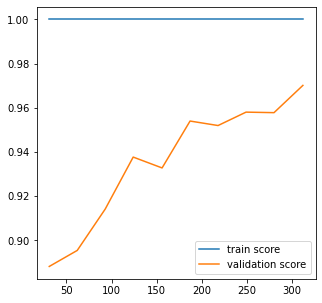

---------------------------------
AdaBoost
Accuracy =  0.9230769230769231
-
[[36  4]
 [ 4 60]]
-
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        40
           1       0.94      0.94      0.94        64

    accuracy                           0.92       104
   macro avg       0.92      0.92      0.92       104
weighted avg       0.92      0.92      0.92       104

-
ACCURACY OF THE MODEL:  0.9230769230769231
Recall score of the model:  0.9375
precision of the model:  0.9375


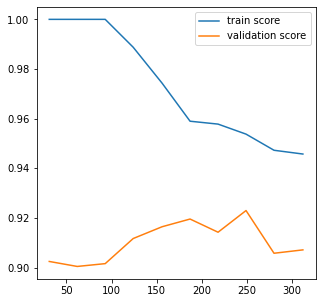

---------------------------------
SVM
Accuracy =  0.9519230769230769
-
[[38  2]
 [ 3 61]]
-
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        40
           1       0.97      0.95      0.96        64

    accuracy                           0.95       104
   macro avg       0.95      0.95      0.95       104
weighted avg       0.95      0.95      0.95       104

-
ACCURACY OF THE MODEL:  0.9519230769230769
Recall score of the model:  0.953125
precision of the model:  0.9682539682539683


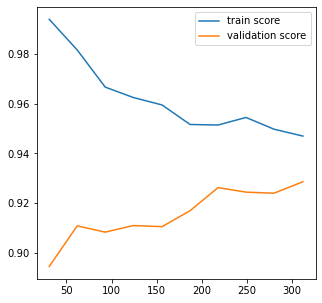

---------------------------------
KNN
Accuracy =  0.9230769230769231
-
[[39  1]
 [ 7 57]]
-
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        40
           1       0.98      0.89      0.93        64

    accuracy                           0.92       104
   macro avg       0.92      0.93      0.92       104
weighted avg       0.93      0.92      0.92       104

-
ACCURACY OF THE MODEL:  0.9230769230769231
Recall score of the model:  0.890625
precision of the model:  0.9827586206896551


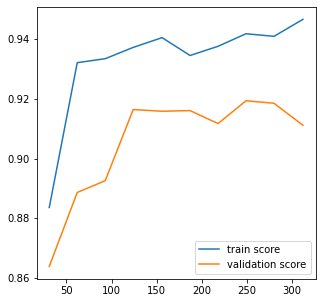

---------------------------------
LR
Accuracy =  0.9038461538461539
-
[[35  5]
 [ 5 59]]
-
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        40
           1       0.92      0.92      0.92        64

    accuracy                           0.90       104
   macro avg       0.90      0.90      0.90       104
weighted avg       0.90      0.90      0.90       104

-
ACCURACY OF THE MODEL:  0.9038461538461539
Recall score of the model:  0.921875
precision of the model:  0.921875


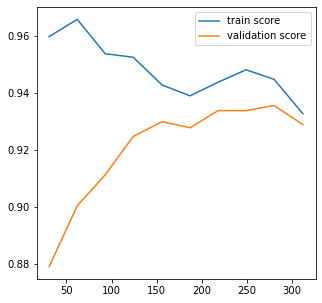

In [22]:
for name, model in dict_of_models.items():
    print('---------------------------------')
    print(name)
    evaluation(model)

## Using RandomForest

In [23]:
rf_start_time = time.time()

In [24]:
RandomPipeline.fit(X_train, y_train)
y_proba = RandomPipeline.predict_proba(X_test)
ypred_RF = np.argmax(y_proba,axis=1)
#print("RandomForest : ", accuracy_score(y_test, ypred_RF))

Text(0.5, 15.0, 'Predicted label')

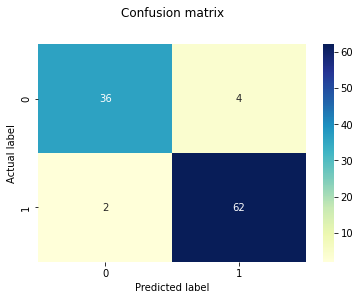

In [25]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, ypred_RF)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [26]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [27]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [28]:
print(multiclass_roc_auc_score(y_test, ypred_RF))

0.9343750000000001


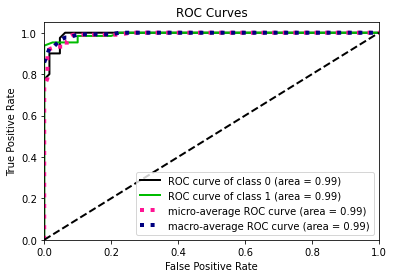

In [29]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = RandomPipeline.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)

In [30]:
# store end time
rf_end = time.time()
time_rf_end = rf_end-rf_start_time
print('Time taken in mins:',time_rf_end/(60))
print('Time taken in hours:',time_rf_end/(60*60))

Time taken in mins: 0.0079758087793986
Time taken in hours: 0.00013293014632331


### Optimization

In [31]:
from sklearn.model_selection import RandomizedSearchCV
RandomPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'randomforestclassifier', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__minmaxscaler', 'pipeline__minmaxscaler__clip', 'pipeline__minmaxscaler__copy', 'pipeline__minmaxscaler__feature_range', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclassifier__warm_start'])

In [32]:
hyper_params = {
    'randomforestclassifier__n_estimators':[10,100,150,250,400,600],
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__min_samples_split':[2,6,12],
    'randomforestclassifier__min_samples_leaf':[1,4,6,10],
    'randomforestclassifier__max_features':['auto','srqt','log2',int,float],
    'randomforestclassifier__n_jobs':[-1],
    'randomforestclassifier__verbose':[0,1,2],
    'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
    'randomforestclassifier__n_jobs':[-1],
}

In [33]:
RF_grid = RandomizedSearchCV(RandomPipeline,hyper_params,scoring='accuracy',n_iter=40)
RF_grid.fit(X_train,y_train)
ypred = RF_grid.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jo

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 333 tas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      |

[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Don

building tree 1 of 10
building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 250 out of 250 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [34]:
ypred_RF = RF_grid.predict(X_test)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.0s finished


In [35]:
print(classification_report(y_test,ypred_RF))
print(accuracy_score(y_test, ypred_RF))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.94      0.95      0.95        64

    accuracy                           0.93       104
   macro avg       0.93      0.93      0.93       104
weighted avg       0.93      0.93      0.93       104

0.9326923076923077


In [36]:
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, ypred_RF))
print("Recall score of the model: ", recall_score(y_test, ypred_RF))
print("precision of the model: ", precision_score(y_test, ypred_RF))

ACCURACY OF THE MODEL:  0.9326923076923077
Recall score of the model:  0.953125
precision of the model:  0.9384615384615385


In [37]:
def multiclass_roc_auc_score(y_test, ypred_RF, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(ypred_RF)
    return roc_auc_score(y_test, ypred_RF, average=average)

In [38]:
print(multiclass_roc_auc_score(y_test, ypred_RF))

0.9265625


Text(0.5, 15.0, 'Predicted label')

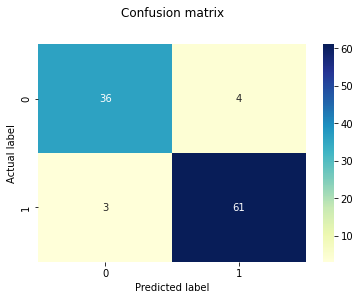

In [39]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, ypred_RF)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Using KNN

In [40]:
knn_start_time = time.time()

Text(0, 0.5, 'Mean Err')

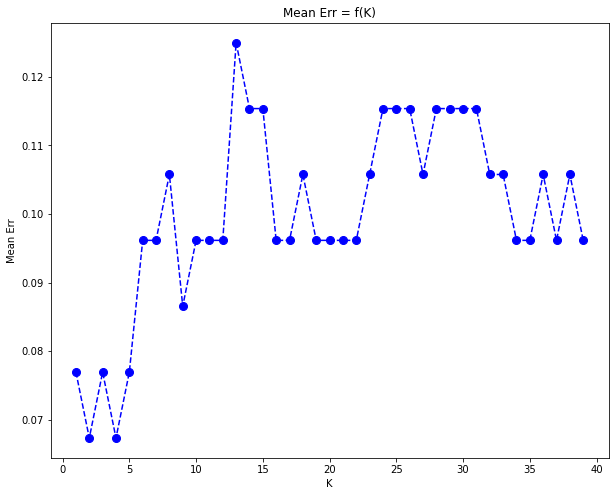

In [41]:
err = []
  
for i in range(1, 40):
    
    model = make_pipeline(preprocessor,KNeighborsClassifier(n_neighbors = i))
    model.fit(X_train, y_train)
    pred_i = model.predict(X_test)
    err.append(np.mean(pred_i != y_test))
  
plt.figure(figsize =(10, 8))
plt.plot(range(1, 40), err, color ='blue',
                linestyle ='dashed', marker ='o',
         markerfacecolor ='blue', markersize = 8)
  
plt.title('Mean Err = f(K)')
plt.xlabel('K')
plt.ylabel('Mean Err')

In [42]:
KNNPipeline = make_pipeline(preprocessor,KNeighborsClassifier(n_neighbors = 34))
KNNPipeline.fit(X_train, y_train)
y_proba = KNNPipeline.predict_proba(X_test)
ypred_KNN = np.argmax(y_proba,axis=1)
print("KNN : ", accuracy_score(y_test, ypred_KNN))

KNN :  0.9038461538461539


In [43]:
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, ypred_KNN))
print("Recall score of the model: ", recall_score(y_test, ypred_KNN))
print("precision of the model: ", precision_score(y_test, ypred_KNN))

ACCURACY OF THE MODEL:  0.9038461538461539
Recall score of the model:  0.859375
precision of the model:  0.9821428571428571


Text(0.5, 15.0, 'Predicted label')

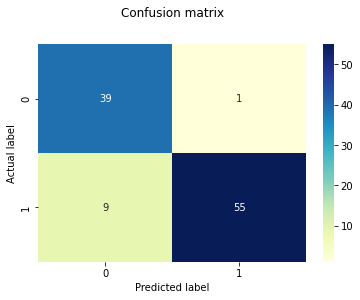

In [44]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, ypred_KNN)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [45]:
# store end time
end_knn = time.time()
time_tkn_knn = end_knn-knn_start_time
print('Time taken in mins:',time_tkn_knn/(60))
print('Time taken in hours:',time_tkn_knn/(60*60))

Time taken in mins: 0.007036761442820231
Time taken in hours: 0.00011727935738033718


## Using XGBoost

In [46]:
XG_start_time = time.time()

Accuracy =  0.9423076923076923
-
[[37  3]
 [ 3 61]]
-
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.95      0.95      0.95        64

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104

-
ACCURACY OF THE MODEL:  0.9423076923076923
Recall score of the model:  0.953125
precision of the model:  0.953125


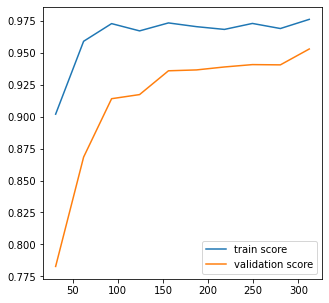

In [47]:
import xgboost as xgb
gbm = xgb.XGBClassifier(
     learning_rate = 0.02,
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     #gamma=1,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     eval_metric = 'logloss',
     nthread= -1,
     scale_pos_weight=1).fit(X_train, y_train)
evaluation (gbm)

In [48]:
ypred_XG=gbm.predict(X_test)

In [49]:
#! pip install scikit-plot
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [50]:
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, ypred_XG))
print("Recall score of the model: ", recall_score(y_test, ypred_XG))
print("precision of the model: ", precision_score(y_test, ypred_XG))

ACCURACY OF THE MODEL:  0.9423076923076923
Recall score of the model:  0.953125
precision of the model:  0.953125


In [51]:
from sklearn.metrics import classification_report, accuracy_score

print(accuracy_score(y_test, ypred_XG))
print(classification_report(y_test, ypred_XG))

0.9423076923076923
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.95      0.95      0.95        64

    accuracy                           0.94       104
   macro avg       0.94      0.94      0.94       104
weighted avg       0.94      0.94      0.94       104



Text(0.5, 15.0, 'Predicted label')

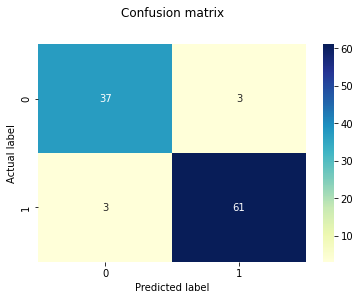

In [52]:
from sklearn import metrics
import seaborn as sns
cnf_matrix = metrics.confusion_matrix(y_test, ypred_XG)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [53]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [54]:
print(multiclass_roc_auc_score(y_test, ypred_XG))

0.9390625


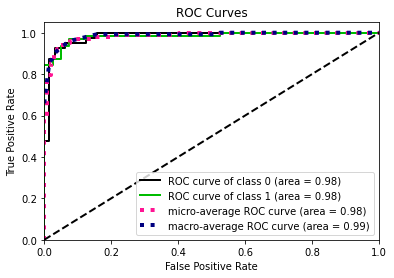

In [55]:
from sklearn.metrics import roc_curve
y_pred_keras_pr = gbm.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_pr)

In [56]:
# store end time
end_XG = time.time()
time_tkn_XG = end_XG-XG_start_time
print('Time taken in mins:',time_tkn_XG/(60))
print('Time taken in hours:',time_tkn_XG/(60*60))

Time taken in mins: 0.40666327079137166
Time taken in hours: 0.006777721179856195


### Using SVM

In [57]:
svm_start_time = time.time()

In [58]:
SVMPipeline.fit(X_train, y_train)
y_proba = SVMPipeline.predict_proba(X_test)
y_pred = np.argmax(y_proba,axis=1)
SVM_score = accuracy_score(y_test, y_pred)
print("SVM : ", SVM_score)

SVM :  0.9519230769230769


In [59]:
SVMPipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'pipeline', 'svc', 'pipeline__memory', 'pipeline__steps', 'pipeline__verbose', 'pipeline__minmaxscaler', 'pipeline__minmaxscaler__clip', 'pipeline__minmaxscaler__copy', 'pipeline__minmaxscaler__feature_range', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])

In [60]:
from sklearn.utils.fixes import loguniform

hyper_params = {
    'svc__C': loguniform(1e0, 1e3),
    'svc__gamma': loguniform(1e-4, 1e-3),
    'svc__kernel': ['rbf'],
    'svc__class_weight':['balanced', None]
               }

In [61]:
SVM_grid = RandomizedSearchCV(SVMPipeline,hyper_params,scoring='accuracy',n_iter=40)
SVM_grid.fit(X_train,y_train)
y_pred_svm = SVM_grid.predict(X_test)
SVM_score = accuracy_score(y_test, y_pred_svm)
print(SVM_score)
print(classification_report(y_test,y_pred_svm))

0.9230769230769231
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        40
           1       0.95      0.92      0.94        64

    accuracy                           0.92       104
   macro avg       0.92      0.92      0.92       104
weighted avg       0.92      0.92      0.92       104



In [62]:
print(multiclass_roc_auc_score(y_test, y_pred_svm))

0.9234375


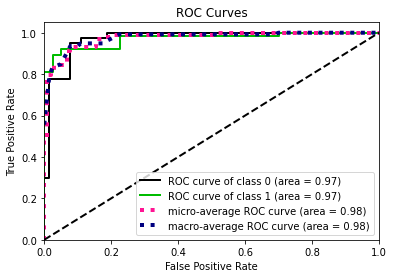

In [63]:
y_pred_keras_svm = SVM_grid.predict_proba(X=X_test)
import scikitplot as skplt
plot = skplt.metrics.plot_roc(y_test, y_pred_keras_svm)

In [64]:
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred_svm))
print("Recall score of the model: ", recall_score(y_test, y_pred_svm))
print("precision of the model: ", precision_score(y_test, y_pred_svm))

ACCURACY OF THE MODEL:  0.9230769230769231
Recall score of the model:  0.921875
precision of the model:  0.9516129032258065


In [65]:
# store end time
end_svm = time.time()
time_tkn_svm = end_svm-svm_start_time
print('Time taken in hours:',time_tkn_svm/(60*60))

Time taken in hours: 0.001150492098596361
